# FomulaBEAT

5桁の数字の偶奇を判定するタスク

4-2-3をベースに変更
- タスクを偶奇判定のタスクに変更
- リファクタリング
- 埋め込み次元を4次元に変更

In [1]:
version = '05-1'
model_dir = './model/' + version
data_path = f'data/eq05-1.txt'
test_data_path = f'data/eq05-1-test.txt'

## 事前定義

In [50]:

# import library
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
from sklearn.decomposition import PCA
import umap
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# 事前設定
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda:0


データの取得

In [23]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [24]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_file(data_path)
print(src_data[:3], tgt_data[:3])


['11681', '78209', '81682'] ['O', 'O', 'E']


辞書データの作成

In [25]:
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [26]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'O': 10, 'E': 11, '<start>': 12, '<end>': 13, '<pad>': 14, '<unk>': 15}


In [27]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[12, 15, 15, 15, 15, 1, 15, 5, 15, 15, 15, 8, 15, 5, 13]

In [28]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  3,  1,  9,  7,  3, 13])
Output: tensor([12, 10, 13])
元に戻した文章
Input: 31973
Output: O


In [29]:
batch_size = 16
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [30]:
len(train_data)

8000

Transoformerの設定

In [31]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [32]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [33]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [34]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [35]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [36]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [37]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [38]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)


In [39]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


13 層

層名: token_embedding.embedding.weight
形状: torch.Size([16, 4])
値: Parameter containing:
tensor([[-0.1668,  0.1294,  0.1120,  0.2835],
        [ 0.2661, -0.3927,  0.0072,  0.5095],
        [-0.2628,  0.1400, -0.2442, -0.0187],
        [-0.0476, -0.5250, -0.2069,  0.1957],
        [-0.2239, -0.4911, -0.3487,  0.4254],
        [-0.1286, -0.4799,  0.4971,  0.5362],
        [-0.1201,  0.0144,  0.3535, -0.3434],
        [-0.5200,  0.1566, -0.0843, -0.1385],
        [ 0.1453, -0.3195, -0.0666, -0.1313],
        [-0.5113,  0.2230, -0.3088, -0.1761],
        [ 0.0298, -0.1197, -0.5171, -0.2952],
        [-0.0067, -0.4411, -0.1749, -0.5449],
        [ 0.3021, -0.1940,  0.2576, -0.3510],
        [ 0.5234, -0.3242, -0.1580,  0.2890],
        [ 0.0870,  0.2855, -0.3297,  0.1554],
        [ 0.1958,  0.4978,  0.2952, -0.5387]], device='cuda:0', requires_grad=True)

層名: decoder_layer.self_attn.in_proj_weight
形状: torch.Size([12, 4])
値: Parameter containing:
tensor([[ 0.0815, -0.2789, -0.1233, -0.53

## 学習実行

In [21]:
epoch = 20
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

# 可視化用に保存
train_losses = []
valid_losses = []

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    print('[{}/{}] train loss: {:.4f}, valid loss: {:.4f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    counter += 1
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    

  0%|          | 0/500 [00:00<?, ?it/s]

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 500/500 [00:05<00:00, 99.95it/s] 


[1/20] train loss: 1.2197, valid loss: 0.4959  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.35it/s]


[2/20] train loss: 0.3230, valid loss: 0.0668  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.61it/s]


[3/20] train loss: 0.0308, valid loss: 0.0148  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.60it/s]


[4/20] train loss: 0.0099, valid loss: 0.0066  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.48it/s]


[5/20] train loss: 0.0049, valid loss: 0.0036  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.43it/s]


[6/20] train loss: 0.0029, valid loss: 0.0022  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.50it/s]


[7/20] train loss: 0.0018, valid loss: 0.0015  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.32it/s]


[8/20] train loss: 0.0012, valid loss: 0.0010  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.43it/s]


[9/20] train loss: 0.0008, valid loss: 0.0007  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.51it/s]


[10/20] train loss: 0.0006, valid loss: 0.0005  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.55it/s]


[11/20] train loss: 0.0004, valid loss: 0.0004  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.65it/s]


[12/20] train loss: 0.0003, valid loss: 0.0003  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.43it/s]


[13/20] train loss: 0.0002, valid loss: 0.0002  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.38it/s]


[14/20] train loss: 0.0002, valid loss: 0.0001  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.46it/s]


[15/20] train loss: 0.0001, valid loss: 0.0001  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.40it/s]


[16/20] train loss: 0.0001, valid loss: 0.0001  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.42it/s]


[17/20] train loss: 0.0001, valid loss: 0.0001  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.39it/s]


[18/20] train loss: 0.0001, valid loss: 0.0000  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.64it/s]


[19/20] train loss: 0.0000, valid loss: 0.0000  [5s] counter: 0 **


100%|██████████| 500/500 [00:04<00:00, 103.49it/s]


[20/20] train loss: 0.0000, valid loss: 0.0000  [5s] counter: 0 **


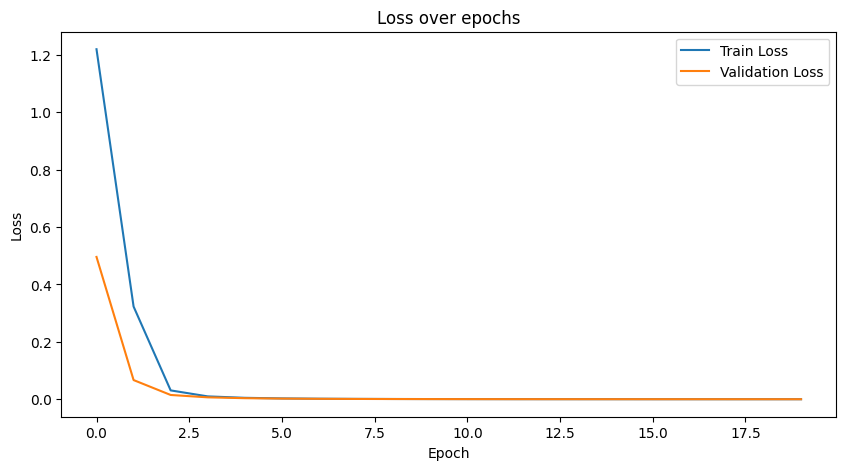

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

学習したモデルの保存

In [23]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [ ]:
# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [25]:
def translate(src_sentence, model=loaded_model, vocab_src=vocab_src, vocab_tgt=vocab_tgt, max_len=50):
    model.eval()
    
    # 数値化されたソース文を生成
    src_indexes = torch.tensor([convert_text_to_indexes(src_sentence, vocab_src)], device=device).transpose(0, 1)

    # 初期ターゲット文に <start> トークンを設定
    tgt_indexes = torch.tensor([START_IDX], device=device).unsqueeze(1)

    # ソース文のメモリを生成
    memory = model.positional_encoding(model.token_embedding(src_indexes))

    for _ in range(max_len):
        # デコード
        output = model.decode(tgt_indexes, memory, generate_square_subsequent_mask(tgt_indexes.size(0)))
        next_token = model.compute_output(output)[-1, :].argmax(1).item()

        # 予測トークンをターゲット文に追加
        tgt_indexes = torch.cat([tgt_indexes, torch.tensor([[next_token]], device=device)], dim=0)

        # <end> トークンで終了
        if next_token == END_IDX:
            break

    # インデックスから文字列に変換
    return convert_indexes_to_text(tgt_indexes.squeeze(1).tolist(), vocab_tgt)


In [26]:
text = "12345"
translation = translate(text)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: 12345
Output: O


In [27]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        return [tuple(line.strip().split(' => ')) for line in file.readlines()]

def calculate_test_accuracy(test_data):
    # テストデータの読み込み
    correct, mistakes = 0, []
    num_test_data = len(test_data)
    for i, (src_text, tgt_text) in enumerate(test_data):
        print(f'{i/num_test_data*100:.2f}%', end='\r')
        translation = translate(src_text)
        if translation == tgt_text:
            correct += 1
        else:
            mistakes.append((src_text, translation, tgt_text))
    return correct/num_test_data, mistakes

# 正答率の計算
test_data = read_file(test_data_path)
accuracy, mistakes = calculate_test_accuracy(test_data)

# 正答率の表示
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Mistakes: {len(mistakes)} out of {len(test_data)}")

# 間違えたケースの一部（10件まで）を表示
print("\nExamples of mistakes:")
for i, (src_text, translation, tgt_text) in enumerate(mistakes[:10]):
    print(f"Input  : {src_text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt_text}")
    print('---')


Test Accuracy: 1.00%
Mistakes: 0 out of 10000

Examples of mistakes:


## モデルの動作を分析

### 初期設定

In [51]:
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')

#loaded_model用のSeq2Seqクラス
class Seq2SeqForSavedModel(Seq2SeqTransformer):
    def __init__(self, *args, **kwargs):
        super(Seq2SeqForSavedModel, self).__init__(*args, **kwargs)
        self.params = dict(self.named_parameters())
        self.pca = None
        self.umap = None

    def positional_encoding(self, tensor: Tensor, maxlen=5000):
        embedding_size = tensor.size(-1)
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)
        return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)
    
    def self_attention(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.params['decoder_layer.self_attn.in_proj_weight'].data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.params['decoder_layer.self_attn.in_proj_bias'].data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.params['decoder_layer.self_attn.out_proj.weight'].data.T) + self.params['decoder_layer.self_attn.out_proj.bias'].data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights
    
    def cross_attention(self, tgt, memory, embedding_size):
        multi_attn_wq, multi_attn_wk, multi_attn_wv = self.params['decoder_layer.multihead_attn.in_proj_weight'].data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = self.params['decoder_layer.multihead_attn.in_proj_bias'].data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
        KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(multi_attn_weights, VW)
        multi_attn_output = torch.matmul(AV, self.params['decoder_layer.multihead_attn.out_proj.weight'].data.T) + self.params['decoder_layer.multihead_attn.out_proj.bias'].data
        return tgt + multi_attn_output.permute(1, 0, 2), multi_attn_output.permute(1, 0, 2), multi_attn_weights
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def predict_next_token(self, src, tgt, embedding_size=embedding_size, device=device):
        memory = self.positional_encoding(self.token_embedding(src))
        tgt_embed = self.positional_encoding(self.token_embedding.embedding.weight[tgt] * math.sqrt(embedding_size))
        tgt_mask = generate_square_subsequent_mask(tgt.size(0)).to(device).type(torch.bool)
        tgt, _, self_attn_weights = self.self_attention(tgt_embed, embedding_size)
        tgt = self.decoder_layer.norm1(tgt)

        tgt, _, multi_attn_weights = self.cross_attention(tgt, memory, embedding_size)
        output = self.compute_output(tgt.transpose(0, 1)[:, -1])

        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        return next_word, self_attn_weights, multi_attn_weights

    def plot_pca(self, original, labels=None):
        if self.pca is None:
            embeddings = self.token_embedding.embedding.weight.detach().cpu().numpy()
            self.pca = PCA(n_components=2)
            self.pca.fit(embeddings)

        embeddings = original.detach().cpu().numpy()
        reduced = self.pca.transform(embeddings)

        # プロット
        plt.figure(figsize=(10, 7))
        for i, (x, y) in enumerate(reduced):
            plt.scatter(x, y, alpha=0.7)
            if labels is not None:
                plt.text(x, y, labels[i], fontsize=9)
        plt.title("PCA Projection of Embeddings with Labels")
        plt.xlabel("PCA-1")
        plt.ylabel("PCA-2")
        plt.show()
    
    def plot_umap(self, original, labels=None):
        if self.umap is None:
            embeddings = self.token_embedding.embedding.weight.detach().cpu().numpy()
            self.umap = umap.UMAP(n_components=2)
            self.umap.fit(embeddings)

        embeddings = original.detach().cpu().numpy()
        reduced = self.umap.transform(embeddings)

        # プロット
        plt.figure(figsize=(10, 7))
        for i, (x, y) in enumerate(reduced):
            plt.scatter(x, y, alpha=0.7)
            if labels is not None:
                plt.text(x, y, labels[i], fontsize=9)
        plt.title("UMAP Projection of Embeddings with Labels")
        plt.xlabel("UMAP-1")
        plt.ylabel("UMAP-2")
        plt.show()

# モデルの初期化
loaded_model = Seq2SeqForSavedModel(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqForSavedModel(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)

In [41]:
# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())
for k, v in params.items():
    print(k, v.shape)

token_embedding.embedding.weight torch.Size([16, 4])
decoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.self_attn.in_proj_bias torch.Size([12])
decoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.self_attn.out_proj.bias torch.Size([4])
decoder_layer.multihead_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.multihead_attn.in_proj_bias torch.Size([12])
decoder_layer.multihead_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.multihead_attn.out_proj.bias torch.Size([4])
decoder_layer.norm1.weight torch.Size([4])
decoder_layer.norm1.bias torch.Size([4])
decoder_layer.norm2.weight torch.Size([4])
decoder_layer.norm2.bias torch.Size([4])


#### テスト実行


In [42]:
text = '11234'

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

next_word, _, _ = loaded_model.predict_next_token(src, ys)

print(f"Input: {text}")
print(f"Output: {convert_indexes_to_text([next_word], vocab_tgt)}")

Input: 11234
Output: E


### 逐次実行で分析

In [25]:
# 初期設定
text = '11234'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

print(f"Input: {text}")
print(f"tokens_src: {tokens_src}")
print(f"src: {src}")
print(f"ys: {ys}")


Input: 11234
tokens_src: [12, 1, 1, 2, 3, 4, 13]
src: tensor([[12],
        [ 1],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [13]], device='cuda:0')
ys: tensor([[12]], device='cuda:0')


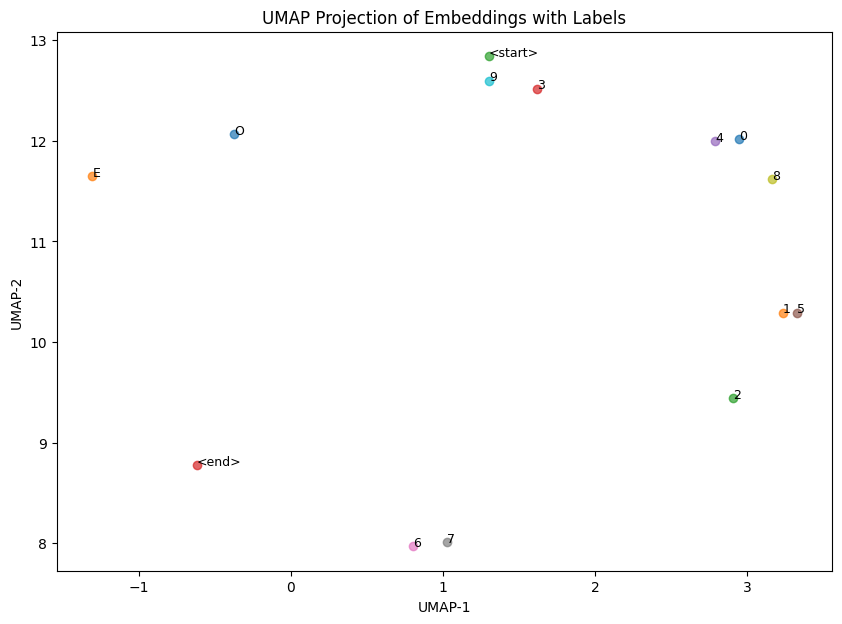

In [ ]:
# 埋め込みのUmapプロット
reverse_vocab = {idx: token for token, idx in vocab_tgt.items()}
loaded_model.plot_umap(loaded_model.token_embedding.embedding.weight[:14, :], list(reverse_vocab.values()))

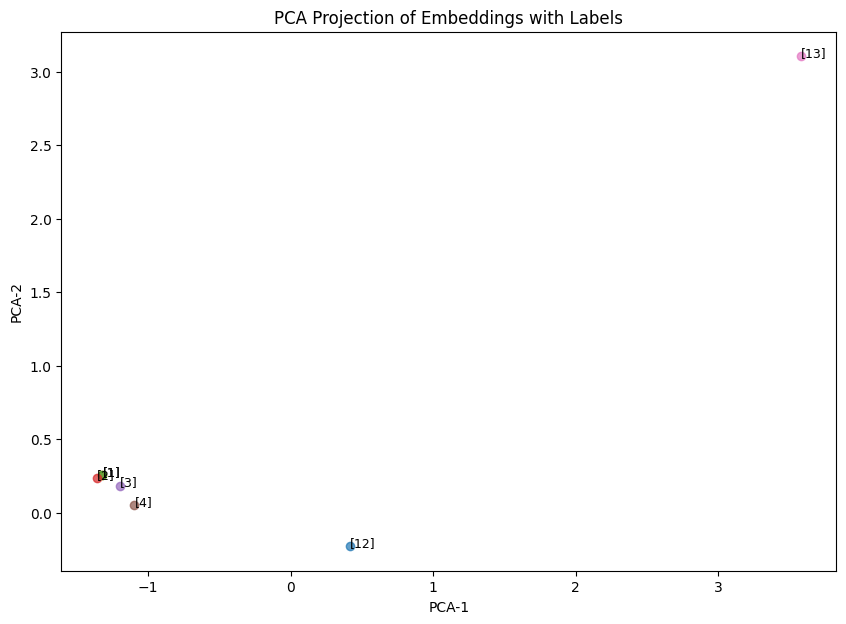

In [27]:
# 埋め込み後のPCAプロット
loaded_model.plot_pca(loaded_model.token_embedding(src).squeeze(1), src.detach().cpu().numpy())

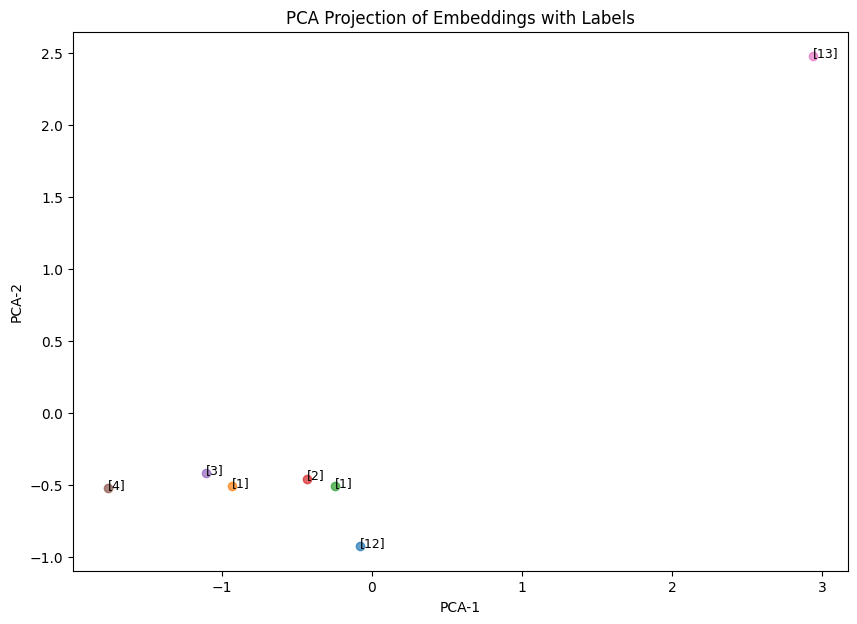

In [28]:
# PE後のPCAプロット
loaded_model.plot_pca(loaded_model.positional_encoding(loaded_model.token_embedding(src)).squeeze(1), src.detach().cpu().numpy())

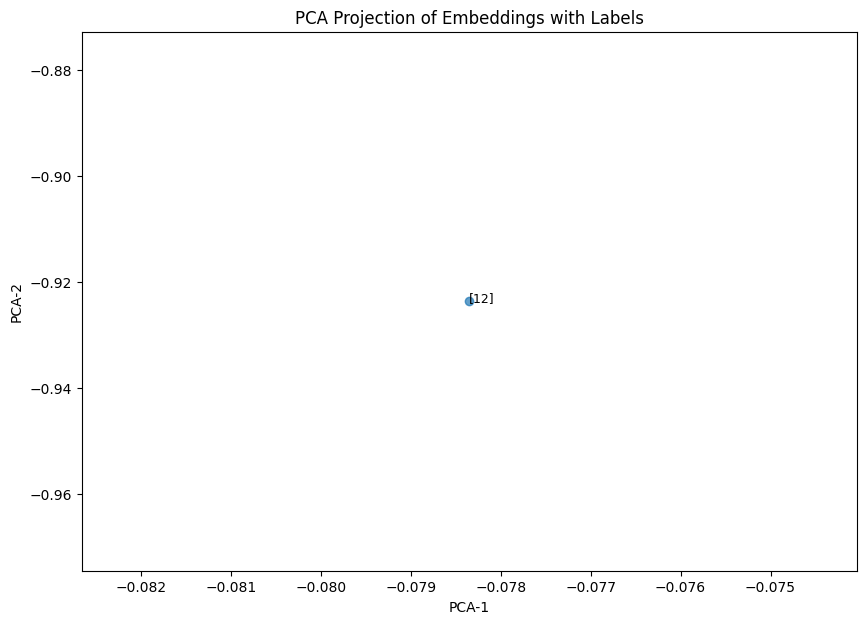

In [29]:
# tgtの埋め込み+PEを可視化
tgt = loaded_model.positional_encoding(loaded_model.token_embedding.embedding.weight[ys] * math.sqrt(embedding_size))
loaded_model.plot_pca(tgt.squeeze(1), ys.detach().cpu().numpy())

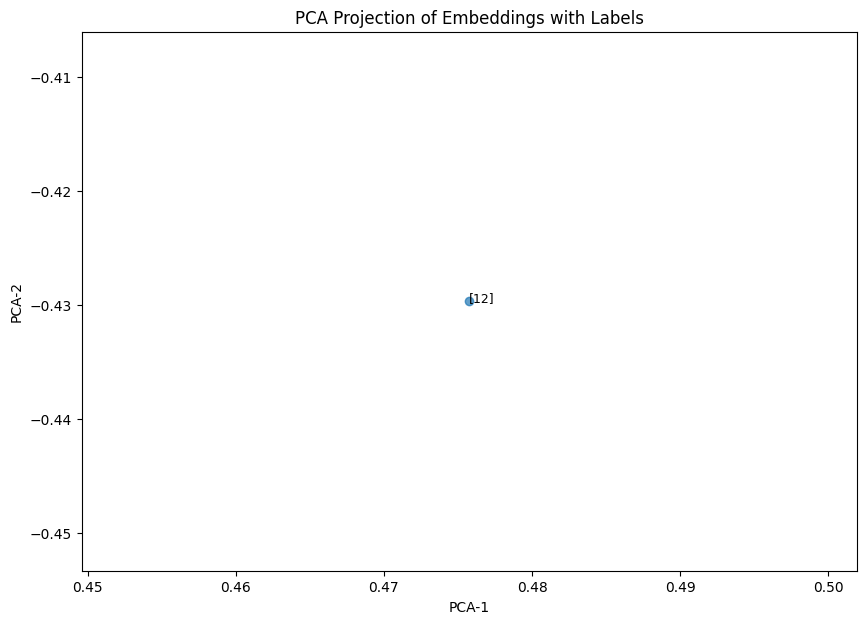

In [30]:
# Self-Attentionの可視化
tgt, _, _ = loaded_model.self_attention(tgt, embedding_size)
loaded_model.plot_pca(tgt.squeeze(1), ys.detach().cpu().numpy())

### 示したいこと１：それぞれの段階で偶奇のデータが分離されている

In [53]:
import random

# 偶数と奇数のデータをランダムに生成
def generate_random_even_odd_data(num_samples=100):
    even_data = []
    odd_data = []
    for _ in range(num_samples):
        even_number = ''.join(str(random.randint(0, 9)) for _ in range(4)) + str(random.choice([0, 2, 4, 6, 8]))
        odd_number = ''.join(str(random.randint(0, 9)) for _ in range(4)) + str(random.choice([1, 3, 5, 7, 9]))
        even_data.append(even_number)
        odd_data.append(odd_number)
    return even_data, odd_data
# ランダムな偶数と奇数データを生成
even_data, odd_data = generate_random_even_odd_data()

# 確認
print("Examples of random even data:", even_data[:5])
print("Examples of random odd data:", odd_data[:5])


Examples of random even data: ['80666', '16252', '84386', '40116', '29318']
Examples of random odd data: ['87261', '13143', '85951', '01177', '29439']


In [ ]:
# PCA plot関数（loaded_modelのpcaを利用）
def plot_pca_even_odd(vectors1, vectors2, model=loaded_model, withEnv=True, label1="Even", label2="Odd"):
    all_vectors = np.vstack((vectors1, vectors2))
    pca = PCA(n_components=2)
    pca.fit(model.token_embedding.embedding.weight.detach().cpu().numpy())
    reduced_vectors = pca.transform(all_vectors)
    plt.figure(figsize=(10, 7))
    # 偶数データをプロット
    plt.scatter(
        reduced_vectors[:len(vectors1), 0],  # 偶数のx座標
        reduced_vectors[:len(vectors1), 1],  # 偶数のy座標
        alpha=0.7, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        reduced_vectors[len(vectors1):, 0],  # 奇数のx座標
        reduced_vectors[len(vectors1):, 1],  # 奇数のy座標
        alpha=0.7, label=label2, color='red'
    )

    # 埋め込みデータのプロット
    if withEnv:
        reduced_embedding = pca.transform(model.token_embedding.embedding.weight.detach().cpu().numpy())
        for i, (x, y) in enumerate(reduced_embedding):
            plt.scatter(x, y, alpha=0.7)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title("PCA Projection of Even and Odd Data (Cross Attention Output)")
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.legend()
    plt.show()



[array([-0.07073593, -0.11862791, -0.02215716,  0.43345022], dtype=float32), array([-0.07073593, -0.11862791, -0.02215716,  0.43345022], dtype=float32), array([-0.07073593, -0.11862791, -0.02215716,  0.43345022], dtype=float32), array([-0.07073593, -0.11862791, -0.02215716,  0.43345022], dtype=float32), array([-0.07073593, -0.11862791, -0.02215716,  0.43345022], dtype=float32)]


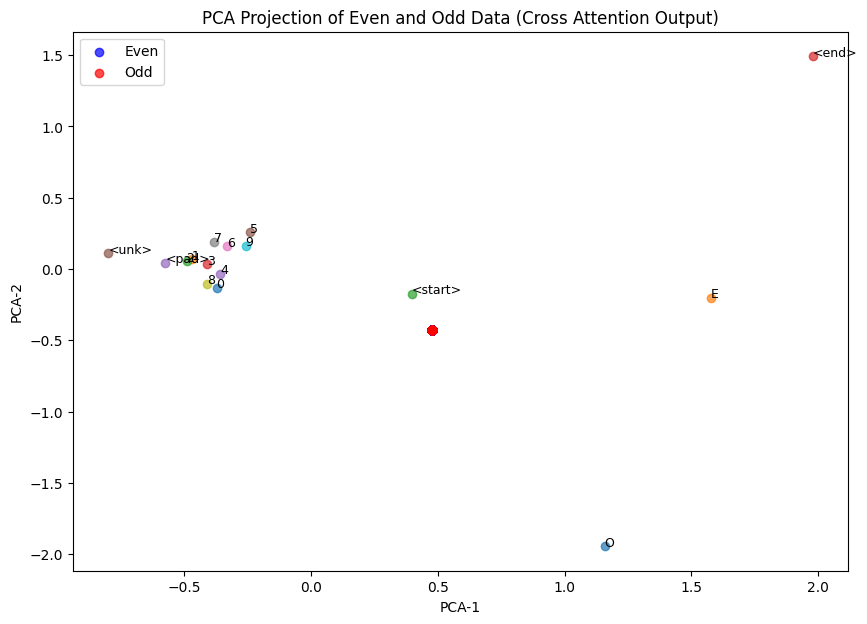

In [ ]:

even_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in even_data]
odd_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in odd_data]

def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding.embedding.weight[torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)] * math.sqrt(embedding_size))
        tgt, _, _ = model.self_attention(tgt, embedding_size)
        vectors.append(tgt.detach().cpu().numpy().squeeze())  # 平均化して次元を整える
    return vectors

# self-attentionのベクトルを抽出
even_vectors_sa = extract_self_attention_vectors(even_src, loaded_model)
odd_vectors_sa = extract_self_attention_vectors(odd_src, loaded_model)
print(even_vectors_sa[:5])model)
# print(even_src_sim_dict["odd_sims"][:5])
plot_pca_even_odd(even_vectors_sa, odd_vectors_sa)

[array([0.33095017, 0.26289552, 0.51079255, 0.56770074], dtype=float32), array([0.30177328, 0.23247164, 0.5203158 , 0.55852723], dtype=float32), array([0.32246634, 0.25064903, 0.5034289 , 0.5695057 ], dtype=float32), array([0.31218776, 0.24258333, 0.5075175 , 0.55481017], dtype=float32), array([0.32235047, 0.25452167, 0.5088189 , 0.5595521 ], dtype=float32)]


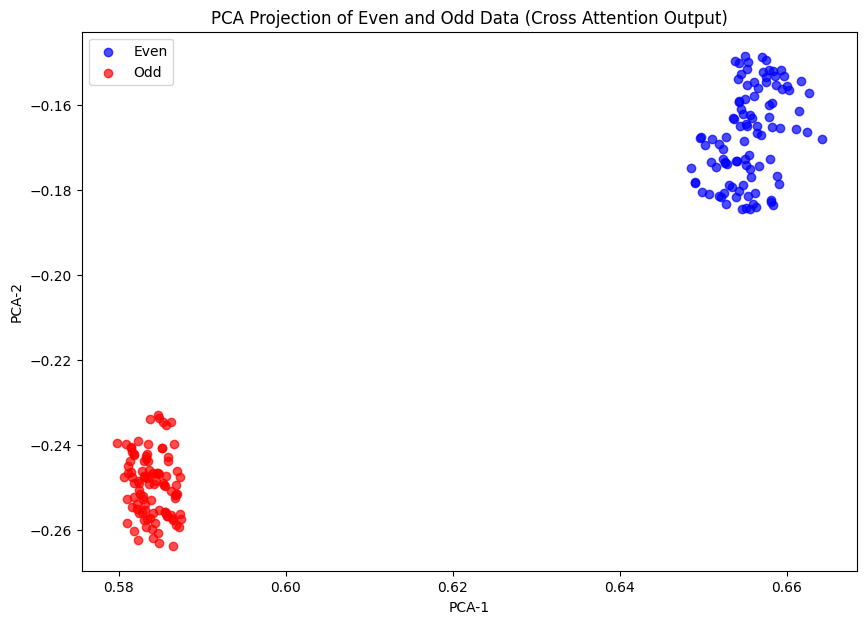

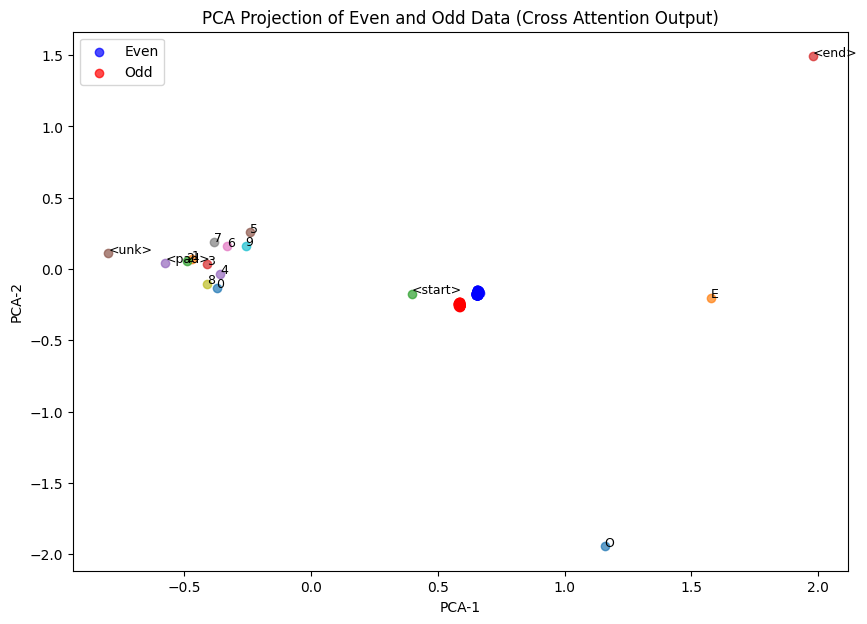

In [69]:

# Cross Attention後の出力を取得
def extract_cross_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory = model.positional_encoding(model.token_embedding(src))
        tgt = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
        tgt = model.positional_encoding(model.token_embedding.embedding.weight[tgt] * math.sqrt(embedding_size))
        tgt, _, _ = model.self_attention(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attention(tgt, memory, embedding_size)
        vectors.append(tgt.transpose(0, 1)[:, -1].detach().cpu().numpy().squeeze())
    return vectors

# 偶数と奇数のCross Attention後のベクトルリストを取得
even_vectors_ca = extract_cross_attention_vectors(even_src, loaded_model)
odd_vectors_ca = extract_cross_attention_vectors(odd_src, loaded_model)
print(even_vectors_ca[:5])
plot_pca_even_odd(even_vectors_ca, odd_vectors_ca, withEnv=False)
plot_pca_even_odd(even_vectors_ca, odd_vectors_ca, withEnv=True)

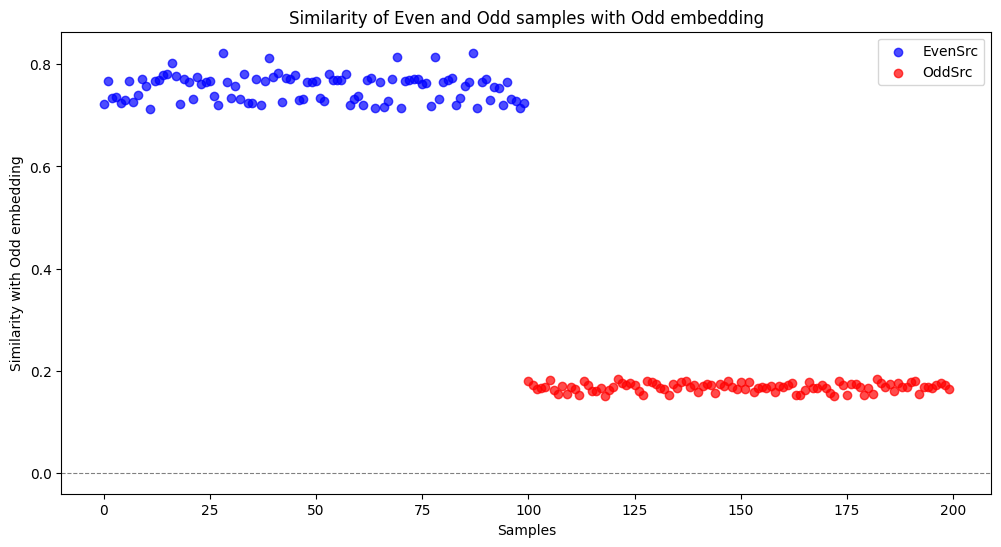

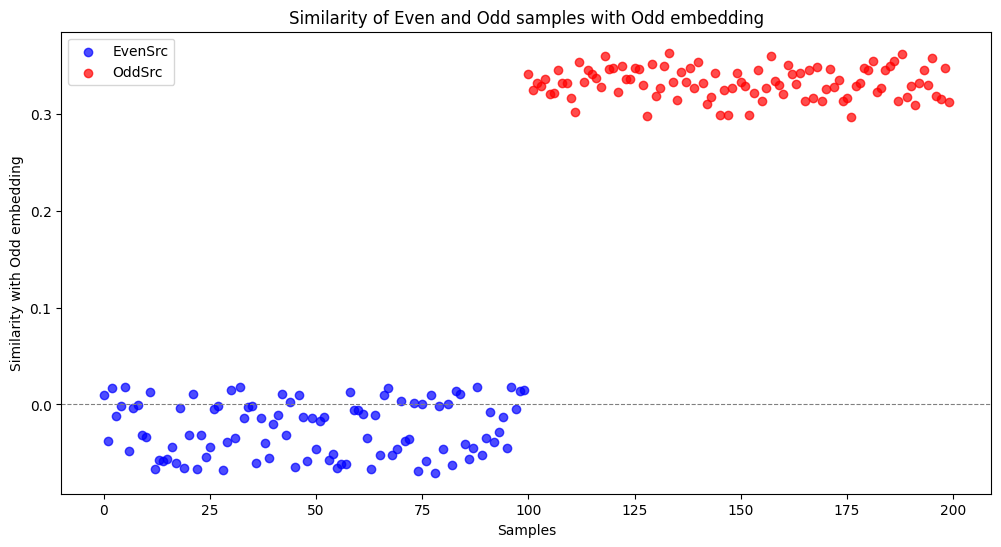

In [75]:
def calculate_similarity(data_src, model=loaded_model):
    even_sims = []
    odd_sims = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory = model.positional_encoding(model.token_embedding(src))
        tgt = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
        tgt_embed = model.positional_encoding(model.token_embedding.embedding.weight[tgt] * math.sqrt(embedding_size))
        tgt, _, _ = model.self_attention(tgt_embed, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attention(tgt, memory, embedding_size)
        output = model.compute_output(tgt.transpose(0, 1)[:, -1]).detach().cpu().numpy().squeeze()
        even_sims.append(output[11])
        odd_sims.append(output[10])
    return {"odd_sims": odd_sims, "even_sims": even_sims}

# 類似度を計算
even_src_sim_dict = calculate_similarity(even_src, loaded_model)
odd_src_sim_dict = calculate_similarity(odd_src, loaded_model)

def plot_similarity_scatter(even_similarities, odd_similarities):
    plt.figure(figsize=(12, 6))

    # 偶数の類似度をプロット（青色）
    plt.scatter(
        range(len(even_similarities)),
        even_similarities,
        color='blue',
        alpha=0.7,
        label='EvenSrc'
    )

    # 奇数の類似度をプロット（赤色）
    plt.scatter(
        range(len(even_similarities), len(even_similarities) + len(odd_similarities)),
        odd_similarities,
        color='red',
        alpha=0.7,
        label='OddSrc'
    )

    # グラフの装飾
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # 基準線
    plt.xlabel("Samples")
    plt.ylabel("Similarity with Odd embedding")
    plt.title("Similarity of Even and Odd samples with Odd embedding")
    plt.legend()
    plt.show()



# 散布図プロット
plot_similarity_scatter(even_src_sim_dict["even_sims"], odd_src_sim_dict["even_sims"])
plot_similarity_scatter(even_src_sim_dict["odd_sims"], odd_src_sim_dict["odd_sims"])

